In [1]:
import getpass
import pandas as pd
import pymysql
import seaborn as sns
import sqlalchemy

from scipy.stats import normaltest
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer, StandardScaler

In [2]:
password = getpass.getpass()
connection_string = 'mysql+pymysql://admin:' + password + '@localhost/sakila'
engine = sqlalchemy.create_engine(connection_string)
engine.execute("USE sakila")

········


In [3]:
query = """select c.customer_id, ct.city
           from customer as c
           join address on c.address_id = address.address_id 
           join city as ct on ct.city_id = address.city_id"""

customer_city = pd.read_sql_query(query, engine)
customer_city.head()

,customer_id,city
0,1,Sasebo
1,2,San Bernardino
2,3,Athenai
3,4,Myingyan
4,5,Nantou


In [4]:
query = """select customer_id, sum(amount) as amount_spent
           from payment
           group by customer_id"""

customer_spent = pd.read_sql_query(query, engine)
customer_spent.head()

,customer_id,amount_spent
0,1,118.68
1,2,128.73
2,3,135.74
3,4,81.78
4,5,144.62


In [5]:
query = """select customer_id, count(inventory_id) as films_rented
           from rental
           group by customer_id"""

customer_films_total = pd.read_sql_query(query, engine)
customer_films_total.head()

,customer_id,films_rented
0,1,32
1,2,27
2,3,26
3,4,22
4,5,38


In [6]:
query = """select c.customer_id, count(r.rental_id) as films_rented_lm
           from rental as r
           right join customer as c on r.customer_id = c.customer_id
               and r.rental_date between 20050515 and 20050530
           group by c.customer_id
           order by c.customer_id"""

customer_films = pd.read_sql_query(query, engine)
customer_films.head()

,customer_id,films_rented_lm
0,1,2
1,2,1
2,3,2
3,4,0
4,5,1


In [7]:
query = """select customer_id, category
           from (select r.customer_id as customer_id, ct.name as category, count(ct.name),
                     row_number() over (partition by r.customer_id order by count(ct.name) desc) as ranking
                 from rental as r
                 join inventory as i on r.inventory_id = i.inventory_id
                 join film_category as fc on fc.film_id = i.film_id
                 join category as ct on ct.category_id = fc.category_id
                 group by ct.name, r.customer_id
                 order by r.customer_id, count(ct.name) desc) t
           where ranking = 1
           order by customer_id"""

customer_category = pd.read_sql_query(query, engine)
customer_category.head()

,customer_id,category
0,1,Classics
1,2,Sports
2,3,Action
3,4,Horror
4,5,Classics


In [8]:
query = """select customer_id, if (films_rented > 1, 1, 0) as rent_this_month
           from (select c.customer_id as customer_id, count(r.rental_id) as films_rented
                 from rental as r
                 right join customer as c on r.customer_id = c.customer_id
                     and r.rental_date between 20050615 and 20050630
                 group by c.customer_id 
                 order by c.customer_id) t"""


next_month = pd.read_sql_query(query, engine)
next_month.head()

,customer_id,rent_this_month
0,1,1
1,2,0
2,3,1
3,4,1
4,5,1


In [9]:
to_join = [customer_city, customer_spent, customer_films_total,
           customer_films, customer_category, next_month]

df = pd.DataFrame(customer_city['customer_id'])

for i in to_join:
    df = pd.merge(df, i, on='customer_id')

df
    
# Also works, but watch out, it joins by index, not by column
# pd.concat(to_join, join='inner', axis=1)    

,customer_id,city,amount_spent,films_rented,films_rented_lm,category,rent_this_month
0,1,Sasebo,118.68,32,2,Classics,1
1,2,San Bernardino,128.73,27,1,Sports,0
2,3,Athenai,135.74,26,2,Action,1
3,4,Myingyan,81.78,22,0,Horror,1
4,5,Nantou,144.62,38,1,Classics,1
...,...,...,...,...,...,...,...
594,595,Jinzhou,117.70,30,1,Documentary,0
595,596,Patras,96.72,28,4,Sports,1
596,597,Sullana,99.75,25,2,Foreign,1
597,598,Lausanne,83.78,22,0,Drama,0


In [10]:
# Now that I have my DF ready, I want to check for nulls
# and explore the columns to see if there data cleaning is needed

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 599 entries, 0 to 598
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   customer_id      599 non-null    int64  
 1   city             599 non-null    object 
 2   amount_spent     599 non-null    float64
 3   films_rented     599 non-null    int64  
 4   films_rented_lm  599 non-null    int64  
 5   category         599 non-null    object 
 6   rent_this_month  599 non-null    int64  
dtypes: float64(1), int64(4), object(2)
memory usage: 37.4+ KB


In [11]:
# Now it's a good time to decide the columns I want to keep
# Remember, you can always change your mind and come back to this step

# Here I see that the customer_id is unique and
# almost no customers live in the same city,
# therefore they are rows that will not benefit my model

len(df['customer_id'].value_counts()), len(df['city'].value_counts())

(599, 597)

In [12]:
# all is fine, no nulls, types are ok, it would be a good idea
# to check unique values for category to check for duality due to misspellings etc

df['category'].value_counts()

Sci-Fi         68
Sports         62
Animation      58
Action         46
Foreign        45
Documentary    45
Family         39
New            35
Games          33
Horror         31
Drama          30
Music          26
Classics       26
Comedy         22
Children       17
Travel         16
Name: category, dtype: int64

In [13]:
# Let's check our numerical data for outliers, need for scaling, etc

df.describe()

,customer_id,amount_spent,films_rented,films_rented_lm,rent_this_month
count,599.000000,599.000000,599.000000,599.000000,599.000000
mean,300.000000,112.548431,26.784641,1.393990,0.893155
std,173.060683,25.370360,5.110357,1.195741,0.309174
min,1.000000,50.850000,12.000000,0.000000,0.000000
25%,150.500000,94.785000,23.000000,0.000000,1.000000
50%,300.000000,110.730000,26.000000,1.000000,1.000000
75%,449.500000,128.705000,30.000000,2.000000,1.000000
max,599.000000,221.550000,46.000000,6.000000,1.000000


In [14]:
# Let's check for multicolinearity to see if we can
# get rid of any other column
# OBS. you want the best result with the need for the least information possible

df[df.columns[:-1]].corr()
# here I removed the target variable because it is categorical,
# and the pearson correlation works best on continuos values
## we will talk more about categorical correlations in class

# below I observe that films_rented and amount_spent are highly correlated
# 'intuitively' I'll choose to drop amount_spent

,customer_id,amount_spent,films_rented,films_rented_lm
customer_id,1.000000,-0.035379,-0.086666,-0.039411
amount_spent,-0.035379,1.000000,0.870511,0.184192
films_rented,-0.086666,0.870511,1.000000,0.187682
films_rented_lm,-0.039411,0.184192,0.187682,1.000000


In [15]:
# Set customer_id as index to know which customer is going to rent,
# but I don't want the id beeing passed as feature (since it has no correlation with the target)
df_clean = df.set_index(df['customer_id'])

# from the observations above, I'll drop the columns:
df_clean = df_clean.drop(['city', 'amount_spent', 'customer_id'], axis=1)

df_clean.head()

,films_rented,films_rented_lm,category,rent_this_month
customer_id,,,,
1,32,2,Classics,1
2,27,1,Sports,0
3,26,2,Action,1
4,22,0,Horror,1
5,38,1,Classics,1


In [16]:
# now let's get dummies
df_final = pd.get_dummies(df_clean)

df_final
# notice that I didn't separate categorical from numericals (the functions are doing it for me)
# but BEWARE always check your dataframe and make sure that you have what you expect

,films_rented,films_rented_lm,rent_this_month,category_Action,category_Animation,category_Children,category_Classics,category_Comedy,category_Documentary,category_Drama,category_Family,category_Foreign,category_Games,category_Horror,category_Music,category_New,category_Sci-Fi,category_Sports,category_Travel
customer_id,,,,,,,,,,,,,,,,,,,
1,32,2,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,27,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,26,2,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,22,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
5,38,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,30,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
596,28,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
597,25,2,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [17]:
# X-y split
X = df_final.drop(['rent_this_month'], axis=1)
y = df_final['rent_this_month']

In [18]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
# the model (changed max_iter because with only 100 (standard)
# the model didn't converge according to warning displayed)
clf = LogisticRegression(random_state=42, max_iter=500).fit(X_train, y_train)
predictions = clf.predict(X_test)

In [20]:
# turning my results into a dataframe just to make sense of it
my_df = pd.DataFrame(X_test).copy()
my_df['predictions'] = predictions
my_df['rent_this_month'] = y_test
# check the two last columns, it is the original label vs the predicted label

In [21]:
my_df

,films_rented,films_rented_lm,category_Action,category_Animation,category_Children,category_Classics,category_Comedy,category_Documentary,category_Drama,category_Family,category_Foreign,category_Games,category_Horror,category_Music,category_New,category_Sci-Fi,category_Sports,category_Travel,predictions,rent_this_month
customer_id,,,,,,,,,,,,,,,,,,,,
111,26,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
420,21,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
565,29,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1
78,31,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1
182,26,2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400,28,3,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1
341,23,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1
149,26,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1


In [22]:
# just to show what accuracy_score is doing
sum(my_df['rent_this_month']) / sum(my_df['predictions']) 

0.9166666666666666

In [23]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, predictions)

0.9166666666666666

In [24]:
# compare predictions to actual answers
print('Confusion matrix')
print(confusion_matrix(predictions,y_test))
print('-------------------------------------------------------')
# accuracy_score
# fitted X_test data vs. y_test data (actual answer)
print('Accuracy score')
print(accuracy_score(predictions,y_test))
print('-------------------------------------------------------')
# classification report
print('Classification report')
print(classification_report(predictions,y_test)) 

Confusion matrix
[[  0   0]
 [ 10 110]]
-------------------------------------------------------
Accuracy score
0.9166666666666666
-------------------------------------------------------
Classification report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.92      0.96       120

    accuracy                           0.92       120
   macro avg       0.50      0.46      0.48       120
weighted avg       1.00      0.92      0.96       120



/home/felipe/anaconda3/envs/data-sci/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [25]:
# bad model, imbalanced data
df_final['rent_this_month'].value_counts()

1    535
0     64
Name: rent_this_month, dtype: int64

In [26]:
# Next step would be to balance the data

### With some sick Feature Engineering

/home/felipe/anaconda3/envs/data-sci/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


NormaltestResult(statistic=8.937347658157284, pvalue=0.011462507018730597)

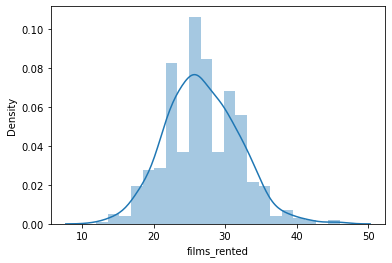

In [27]:
# looks normal distributed
sns.distplot(df_final['films_rented'])
# the pvalue agrees
normaltest(df_final['films_rented'])
# null hypothesis: comes from a normal distribution
# if pvalue < 0.05 it might be a Normal distribution

In [28]:
# Let's scale the data to check if we get better results
# my intuition is that it won't (the magnitude from the columns are not so expressive)

# Here I'll choose Standard Scaler since the distribution is normal
# but using Normalizer is not a bad option

# initialize the object
scaler = StandardScaler()
# fit to get the transformation 'equation'
scaler.fit(df_final[['films_rented']]) # I'm using [[]] to get a 2D array 
# Fit only on the trainning data
# if you fit on the entire data the trainning data will carry information from the testing data
# also, you lose the opportunity to check the full effect of the normalization

# apply the transformation 'equation to your data'
df_final['films_rented'] = scaler.transform(df_final[['films_rented']]) # again with the [[]]
# OBS. to save time you don't have to turn it back into a dataframe, I'm doing it
# just to show what each step is doing to the data
df_final

,films_rented,films_rented_lm,rent_this_month,category_Action,category_Animation,category_Children,category_Classics,category_Comedy,category_Documentary,category_Drama,category_Family,category_Foreign,category_Games,category_Horror,category_Music,category_New,category_Sci-Fi,category_Sports,category_Travel
customer_id,,,,,,,,,,,,,,,,,,,
1,1.021400,2,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,0.042177,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,-0.153668,2,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,-0.937046,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
5,2.196467,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,0.629711,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
596,0.238021,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
597,-0.349512,2,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


/home/felipe/anaconda3/envs/data-sci/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='films_rented', ylabel='Density'>

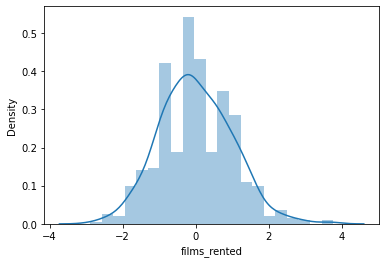

In [29]:
sns.distplot(df_final['films_rented'])
# the shape didn't change, but the x axis is scaled

In [30]:
# rinse and repeat
X = df_final.drop(['rent_this_month'], axis=1)
y = df_final['rent_this_month']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = LogisticRegression(random_state=42, max_iter=500).fit(X_train, y_train)
predictions = clf.predict(X_test)

# compare predictions to actual answers
print('Confusion matrix')
print(confusion_matrix(predictions,y_test))
print('-------------------------------------------------------')
# accuracy_score
# fitted X_test data vs. y_test data (actual answer)
print('Accuracy score')
print(accuracy_score(predictions,y_test))
print('-------------------------------------------------------')
# classification report
print('Classification report')
print(classification_report(predictions,y_test)) 

Confusion matrix
[[  0   0]
 [ 10 110]]
-------------------------------------------------------
Accuracy score
0.9166666666666666
-------------------------------------------------------
Classification report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.92      0.96       120

    accuracy                           0.92       120
   macro avg       0.50      0.46      0.48       120
weighted avg       1.00      0.92      0.96       120



/home/felipe/anaconda3/envs/data-sci/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
